## Tensorflowで"Semi-supervised Clustering for Short Text via Deep Representation Learning"の実装¶
http://aclweb.org/anthology/K16-1004

In [1]:
import tensorflow as tf
import numpy as np
import sys
import random as rd
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec
import MeCab
import subprocess
import itertools
import string
import sqlite3
from keras.preprocessing import sequence
rng = np.random.RandomState(1234)

Using TensorFlow backend.


# 1.データの準備

In [2]:
#
#ここで各ファイルのパスを設定します。
#

#学習に用いるデータ
dbpath = "../input/category_walkerplus.db"

#word2vecのモデル
model_path="../input/word2vec.gensim.model"

#辞書
dic_path="/usr/local/lib/mecab/dic/mecab-ipadic-neologd"

In [3]:
model = Word2Vec.load(model_path)
tagger = MeCab.Tagger("-Ochasen -d {0}".format(dic_path))

In [4]:
def cur(sourcedbname):
    con = sqlite3.connect(sourcedbname)
    cur = con.cursor()   
    sql = "select * from events"
    cur.execute(sql)
    return cur

In [5]:
Cur=cur(dbpath)

labels=[]
texts=[]
for row in Cur:
    labels.append(row[0].replace("[","").replace("]","").split(",")[1].replace(" ",""))  #Big Category
    texts.append(row[1])

## 分散表現の獲得
Data：入力の文章を分かち書きしw2vで埋め込み後padding shape=(データ数,maxlen,埋め込み次元)<br/>
Labels:正解ラベル

#### 分かち書き

In [6]:
def _tokenize(text):
    sentence = []
    node = tagger.parse(text)
    #print node
    node = node.split("\n")
    for i in range(len(node)):
        feature = node[i].split("\t")
        if feature[0] == "EOS":
            break
        hinshi = feature[3].split("-")[0]
        if "名詞" in hinshi:
            #sentence.append(feature[2].decode('utf-8'))
            sentence.append(feature[2])
        elif "形容詞" in hinshi:
            #sentence.append(feature[2].decode('utf-8'))
            sentence.append(feature[2])
        elif "動詞" in hinshi:
            #sentence.append(feature[2].decode('utf-8'))
            sentence.append(feature[2])
        elif "形容動詞" in hinshi:
            #sentence.append(feature[2].decode('utf-8'))
            sentence.append(feature[2])
        elif "連体詞" in hinshi:
            #sentence.append(feature[2].decode('utf-8'))
            sentence.append(feature[2])           
        elif "助詞" in hinshi:
            #sentence.append(feature[2].decode('utf-8'))
            sentence.append(feature[2])
            
    return sentence

### 分散表現の獲得

In [7]:
def getVector(text):
    texts = _tokenize(text)
    v = []
    for t in texts:
        if t in model.wv:
            if v == []:
                v = model.wv[t]
            else:
                v = np.vstack((v,model.wv[t]))
    if v != []:
        return v
    else:
        return np.array([])

In [8]:
Data=np.array([getVector(text) for text in texts])

/Users/tomoki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/Users/tomoki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


In [9]:
Data = sequence.pad_sequences(Data, padding="post", truncating="post",dtype="float32")  #padding  

In [10]:
label2Label={name:i for i,name in enumerate(np.unique(labels))}  #label(名前)->Label(数字)
Labels=np.array([label2Label[label] for label in labels])  

# 2.教師データの選択

In [11]:
def load_data(Data,Labels,training_percent=0.9, supervise_percent=0.1):
    """
    Args:
        Data：入力の文章を分かち書きしw2vで埋め込み後padding shape=(データ数,maxlen,埋め込み次元)
        Labels:正解ラベル
        training_percent:trainingデータに使用する割合
        supervise_percent: supervise(教師データ)として一部与える割合(training_dataに対して)
    Returns:
        train_X:Dataの学習用
        train_y:Labelsの学習用
        test_X:Dataのテスト用
        test_y:Labelsのテスト用
        supervised:学習用データにおいて一部与える教師データのindex
    """
    #trainとtestでclassが均等になるようにsplit
    cluster_num=np.unique(Labels)
    train_index = []
    
    for i in range(len(cluster_num)):
        num = Labels[Labels==i].shape[0]
        k = int(num*training_percent)
        train_index.extend(rd.sample(list(np.where(Labels==i)[0]),k))
    
    #text classification for cnn のためにあらかじめlayerを追加
    train_X = Data[train_index][:,:,:,np.newaxis]
    train_y = Labels[train_index]
    test_X = np.delete(Data,train_index,0)[:,:,:,np.newaxis]
    test_y = np.delete(Labels,train_index,0)
    
    supervised = []

    for i in range(len(cluster_num)):
        num = train_y[train_y==i].shape[0]
        k = int(num*supervise_percent)
       
        supervised.extend(rd.sample(list(np.where(train_y==i)[0]),k))

    
    return train_X,train_y,test_X,test_y,supervised

In [12]:
train_X,train_y,test_X,test_y, supervised = load_data(Data,Labels,supervise_percent=0.5)

## 3.CNN for Text Classificationの実装

### HyperParams

In [13]:
#窓の幅
filter_sizes = [3,5,7]
#分散表現の次元
vector_length = train_X.shape[2]
#最大系列長
sequence_length = train_X.shape[1]
#フィルターの枚数
num_filters = 16
#隠れ層
hid_dim=100
#出力次元数
output_dim=100
#クラスタリングするクラス多数
n_cluster=len(np.unique(train_y))

alpha=0.01
l=0

In [14]:
class Conv:
    def __init__(self, sequence_length,embedding_size,filter_sizes, num_filters):
        self.sequence_length=sequence_length
        self.embedding_size=embedding_size
        self.filter_sizes=filter_sizes
        self.num_filters=num_filters
    def f_prop(self,x):
        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(self.filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, self.embedding_size, 1, self.num_filters]
                
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[self.num_filters]), name="b")
                conv = tf.nn.conv2d(
                    x,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, self.sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(self.filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])
        return self.h_pool_flat

class Dense:
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        # Xavier initializer
        self.W = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/(in_dim + out_dim)),
                        high=np.sqrt(6/(in_dim + out_dim)),
                        size=(in_dim, out_dim)
                    ).astype('float32'), name='W')
        self.b = tf.Variable(np.zeros([out_dim]).astype('float32'))
        self.function = function

    def f_prop(self, x):
        return self.function(tf.matmul(x, self.W) + self.b)
        
class LinearDense:
    def __init__(self, in_dim, out_dim):
        # Xavier initializer
        self.W = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/(in_dim + out_dim)),
                        high=np.sqrt(6/(in_dim + out_dim)),
                        size=(in_dim, out_dim)
                    ).astype('float32'), name='W')
        self.b = tf.Variable(np.zeros([out_dim]).astype('float32'))

    def f_prop(self, x):
        return tf.matmul(x, self.W) + self.b

### グラフの構築

In [15]:
input_x = tf.placeholder(tf.float32, [None, sequence_length,vector_length,1], name="input_x")
input_t = tf.placeholder(tf.float32, [None, output_dim], name="input_y")

layers = [
    Conv(sequence_length=sequence_length,
         embedding_size=vector_length,
         filter_sizes=filter_sizes,
         num_filters=num_filters),
    Dense(num_filters * len(filter_sizes),hid_dim , tf.nn.tanh),
    LinearDense(hid_dim, output_dim)
]

def f_props(layers, x):
    for i, layer in enumerate(layers):
        x = layer.f_prop(x)
    return x

pred_y = f_props(layers, input_x)


### 誤差関数の設計
<img src='../img/jsemi.png'>

In [16]:
#目的関数の定義
def _cost(pred_y, centers, neighbor_index, sup_index, mask):
    """
    Args:
        pred_y: text-cnn の出力
        centers:各ラベルごとの重心 shape=(cluster_num, output_dim)
        neighbor_index:train_Xがどの重心に最も近いか shape=(data_num,)
        sup_index:教師データとして用いるtrain_Xの対応するクラスターID index shape=(sup_num,)
        mask:教師データとして用いるindexに1、それ以外に0が入ったmask
    """
    
    term1= tf.reduce_sum(tf.square(pred_y - tf.gather(centers, neighbor_index)))    
    term1_1 = alpha*tf.cast(term1, tf.float32)
    
    
    term2 = tf.reduce_sum(mask * tf.square(pred_y - tf.gather(centers, sup_index) ))
    term2_1 = (1-alpha)*tf.cast(term2, tf.float32)

    cost = tf.add(term1_1, term2_1)
    
    for i in range(n_cluster):
        i_index = i * tf.ones_like(sup_index, dtype='int32')
        
        x1 = tf.reduce_sum(mask*tf.square(pred_y - tf.gather(centers, sup_index)),1)#正解の重心との距離
        x2 = tf.reduce_sum(mask*tf.square(pred_y - tf.gather(centers, i_index)),1)     #クラスターIDがiの重心との距離
        x1 = tf.reshape(x1, [-1, 1])
        x2 = tf.reshape(x2, [-1, 1])
        
        term2_2 = l+x1-x2
        
        condition = tf.greater(term2_2, 0)
        term2_3 = tf.reduce_sum(mask * tf.where(condition, term2_2, tf.zeros_like(term2_2)))
        term2_3 = tf.cast(term2_3, tf.float32)

        cost=tf.add(cost, (1-alpha)*term2_3)
        
    return cost

In [17]:
#  centers:各ラベルごとの重心 shape=(cluster_num, output_dim) 
centers= tf.placeholder(tf.float32, [None, output_dim], name="centers")

#  neighbor_index:train_Xがどの重心に最も近いか shape=(data_num,)
neighbor_index= tf.placeholder(tf.int32, [None], name="neighbor_index")

#  sup_index:教師データとして用いるtrain_Xの対応するクラスターID shape=(sup_num,)
sup_index=tf.placeholder(tf.int32, [None], name="supervised_index")

#  mask:教師データとして用いるindexに1、それ以外に0が入ったmask
mask=tf.placeholder(tf.float32, [None,1], name="mask")

#自作の誤差関数
cost = _cost(pred_y, centers, neighbor_index, sup_index, mask)

# 最小化にはAdamを用いる
train = tf.train.AdamOptimizer().minimize(cost)

# 4.Iteration
<img src='../img/iter.png'>

In [18]:
def assign_to_nearest(samples, centroids):
    """
    Args:
        samples:text-cnn後の出力
        centroids:クラスターそれぞれの重心 shape=(cluster_num,output_dim)
    Returns:
        nearest: 入力データと最も近いクラスターID shape=(data_num, )
    """
    #1-1.KNearest Neighborで一番近いクラスタと紐付け
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(centroids, np.arange(len(centroids)))
    nearest = neigh.predict(samples)
    
    #1-2.ハンガリアンアルゴリズムでラベル付きデータと重心を紐付ける
    
    sup_labels =train_y[supervised]
    hglabel = np.unique(sup_labels)
    
    hgx=[]  #教師データのラベルごとに平均した点（重心）を求める
    for i in hglabel:
        ind=np.where(sup_labels==i)[0]
        hgx.append(np.mean(samples[supervised][ind], axis=0))
    hgx = np.array(hgx)

    #教師ラベルごとの重心と現在の重心との距離行列
    DistanceMatrix = np.linalg.norm(hgx[:,np.newaxis,:]-centroids[np.newaxis,:,:],axis=2)  
    
    # ハンガリアンアルゴリズムで合計が一番小さくなるように紐づける 
    from scipy.optimize import linear_sum_assignment
    row_ind, col_ind = linear_sum_assignment(DistanceMatrix)
    
    #ラベルとclusterIDを紐づける
    label2id={hglabel[i]:col for i,col in enumerate(col_ind)}
    
    
    return nearest ,label2id

In [19]:
def estimate_centroids(samples, nearest, label2id, use_supervised=True):
    """
    重心を再推定する
    重心の再推定式は簡略化してラベル付きと無しの加重平均
    Args:
        samples:text-cnn後の出力
        nearest: 入力データと最も近いクラスターID shape=(data_num, )
        label2id:labelとクラスターIDを紐づけるdict
        use_supervised:教師データを用いるかどうか（checkの際K-Meansが上手くいくか検証する際に用いいる）
    Returns:
        centroids:クラスターそれぞれの重心 shape=(cluster_num,output_dim)
        sup_cent:一部の教師データごとに現時点で対応するIDの重心が入った配列
    """
    sup_pred=samples[supervised]
    newce=np.array([label2id[t] for t in train_y[supervised]]) #現時点での一部の教師データと対応するクラスターIDの配列
            
    centroids=[]
    for i in range(n_cluster):
        sum1 = np.sum(alpha*len(np.where(nearest==i)[0]))
        sum2 = np.sum(alpha*samples[nearest==i], axis=0)
    
        if use_supervised:
            
            sum33 = np.sum((1-alpha)*len(np.where(newce==i)[0]))
            sum44 = np.sum((1-alpha)*sup_pred[newce==i], axis=0)
            
            centroids.append((sum2+sum44)/(sum1+sum33))
            
        else:
            centroids.append((sum2)/(sum1))
            
    centroids = np.array(centroids) 

    #3.NNのパラメータ更新
    sup_cent = np.array([centroids[c_id] for c_id in newce])
    
    return centroids, sup_cent



# 5.学習

In [20]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
# 学習に関するHyperParams 
max_epochs=300

nb_epoch=1 #バッチ学習一周を何回行うか
batch_size = 32
n_batches = train_X.shape[0]//batch_size


#初期値獲得
samples=sess.run(pred_y, feed_dict={input_x:train_X})
centroids = np.array(rd.sample(list(samples),n_cluster))

#Mask
mask_array = np.zeros(len(train_X), dtype=int)
mask_array[supervised] = 1        
    

for iters in range(max_epochs):
    print("Epoch : ",iters)
    savename="../output/{0:03d}".format(iters)
    
    samples=sess.run(pred_y, feed_dict={input_x:train_X})
    
    nearest, label2id = assign_to_nearest(samples, centroids)

    centroids, sup_cent = estimate_centroids(samples, nearest, label2id, use_supervised=True)
    

    
    newce=np.array([label2id[t] for t in train_y])  #正解ラベル->対応するクラスターIDした配列    
    
    for _ in tqdm(range(nb_epoch)):
        shuffled_train_X,  shuffled_train_y, shuffled_nearest, shuffled_newce, shuffled_mask =shuffle(train_X,train_y, nearest, newce,mask_array)
       
        for i in range(n_batches):  
            start = i * batch_size
            end = start + batch_size

            batch_X = shuffled_train_X[start:end]
            batch_y = shuffled_train_y[start:end]
            batch_nearest = shuffled_nearest[start:end]
            batch_newce   = shuffled_newce[start:end]
            batch_mask     = shuffled_mask[start:end].reshape(-1,1)

            sess.run(train, feed_dict={input_x:batch_X, centers : centroids, neighbor_index:batch_nearest, sup_index:batch_newce, mask:batch_mask })
   
    
    #収束を確認
    if iters>0:
        if np.all(nearest== prev_nearest):
                break
        else:
                from sklearn.metrics import accuracy_score
                print(accuracy_score(nearest, prev_nearest))
                prev_nearest = nearest
                
    else:
                prev_nearest = nearest

Epoch :  0


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


Epoch :  1


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


0.313099041534
Epoch :  2


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


0.623402555911
Epoch :  3


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


0.816293929712
Epoch :  4


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


0.562699680511
Epoch :  5


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


0.535143769968
Epoch :  6


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


0.585862619808
Epoch :  7


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


0.702076677316
Epoch :  8


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


0.544728434505
Epoch :  9


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


0.531549520767
Epoch :  10


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


0.255191693291
Epoch :  11


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


0.247204472843
Epoch :  12


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


0.45447284345
Epoch :  13


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


0.211261980831
Epoch :  14


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


0.390575079872
Epoch :  15


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


0.634185303514
Epoch :  16


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


0.658945686901
Epoch :  17


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


0.591453674121
Epoch :  18


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


0.673322683706
Epoch :  19


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


0.530750798722
Epoch :  20


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


0.691693290735
Epoch :  21


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


0.68250798722
Epoch :  22


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


0.492811501597
Epoch :  23


100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


0.639776357827
Epoch :  24


100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


0.863817891374
Epoch :  25


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


0.424520766773
Epoch :  26


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


0.551118210863
Epoch :  27


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


0.880990415335
Epoch :  28


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


0.821485623003
Epoch :  29


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


0.825479233227
Epoch :  30


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


0.884984025559
Epoch :  31


100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


0.897364217252
Epoch :  32


100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


0.892971246006
Epoch :  33


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


0.919329073482
Epoch :  34


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


0.963258785942
Epoch :  35


100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


0.962460063898
Epoch :  36


100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


0.836261980831
Epoch :  37


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


0.678115015974
Epoch :  38


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


0.856629392971
Epoch :  39


100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


0.78554313099
Epoch :  40


100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


0.847843450479
Epoch :  41


100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


0.680511182109
Epoch :  42


100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


0.683706070288
Epoch :  43


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


0.384185303514
Epoch :  44


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


0.131389776358
Epoch :  45


100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


0.0343450479233
Epoch :  46


100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


0.105031948882
Epoch :  47


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


0.636182108626
Epoch :  48


100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


0.0982428115016
Epoch :  49


100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


0.106629392971
Epoch :  50


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


0.865015974441
Epoch :  51


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


0.89017571885
Epoch :  52


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


0.904552715655
Epoch :  53


100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


0.94249201278
Epoch :  54


100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


0.885383386581
Epoch :  55


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


0.967651757188
Epoch :  56


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


0.950878594249
Epoch :  57


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


0.98482428115
Epoch :  58


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


0.97124600639
Epoch :  59


100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


0.948083067093
Epoch :  60


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


0.922124600639
Epoch :  61


100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


0.983226837061
Epoch :  62


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


0.938897763578
Epoch :  63


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


0.941293929712
Epoch :  64


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


0.922124600639
Epoch :  65


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


0.950479233227
Epoch :  66


100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


0.969249201278
Epoch :  67


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


0.969249201278
Epoch :  68


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


0.976437699681
Epoch :  69


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


0.947284345048
Epoch :  70


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


0.96285942492
Epoch :  71


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


0.922124600639
Epoch :  72


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


0.911741214058
Epoch :  73


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


0.9696485623
Epoch :  74


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


0.986022364217
Epoch :  75


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


0.977236421725
Epoch :  76


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


0.946485623003
Epoch :  77


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


0.308306709265
Epoch :  78


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


0.0163738019169
Epoch :  79


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


0.265974440895
Epoch :  80


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


0.125798722045
Epoch :  81


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


0.772763578275
Epoch :  82


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


0.146565495208
Epoch :  83


100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


0.749201277955
Epoch :  84


100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


0.818690095847
Epoch :  85


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


0.696884984026
Epoch :  86


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


0.889376996805
Epoch :  87


100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


0.896166134185
Epoch :  88


100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


0.967252396166
Epoch :  89


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


0.981629392971
Epoch :  90


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


0.980431309904
Epoch :  91


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


0.978434504792
Epoch :  92


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


0.964856230032
Epoch :  93


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


0.973242811502
Epoch :  94


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


0.980031948882
Epoch :  95


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


0.990015974441
Epoch :  96


100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


0.979233226837
Epoch :  97


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


0.989217252396
Epoch :  98


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


0.992811501597
Epoch :  99


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


0.975239616613
Epoch :  100


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


0.947284345048
Epoch :  101


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


0.987220447284
Epoch :  102


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


0.982428115016
Epoch :  103


100%|██████████| 1/1 [00:03<00:00,  3.44s/it]


0.950079872204
Epoch :  104


100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


0.957667731629
Epoch :  105


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


0.981230031949
Epoch :  106


100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


0.987619808307
Epoch :  107


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


0.987619808307
Epoch :  108


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


0.937300319489
Epoch :  109


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


0.961661341853
Epoch :  110


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


0.988817891374
Epoch :  111


100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


0.972444089457
Epoch :  112


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


0.975239616613
Epoch :  113


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


0.981629392971
Epoch :  114


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


0.972044728435
Epoch :  115


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


0.988418530351
Epoch :  116


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


0.985223642173
Epoch :  117


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


0.934504792332
Epoch :  118


100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


0.931709265176
Epoch :  119


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


0.955670926518
Epoch :  120


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


0.904153354633
Epoch :  121


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


0.356629392971
Epoch :  122


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


0.660143769968
Epoch :  123


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


0.138178913738
Epoch :  124


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


0.479233226837
Epoch :  125


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


0.655750798722
Epoch :  126


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


0.407747603834
Epoch :  127


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


0.436900958466
Epoch :  128


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


0.894169329073
Epoch :  129


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


0.921325878594
Epoch :  130


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


0.958067092652
Epoch :  131


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


0.95607028754
Epoch :  132


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


0.954872204473
Epoch :  133


100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


0.946485623003
Epoch :  134


100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


0.906549520767
Epoch :  135


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


0.96445686901
Epoch :  136


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


0.948083067093
Epoch :  137


100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


0.9696485623
Epoch :  138


100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


0.994009584665
Epoch :  139


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


0.992412140575
Epoch :  140


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


0.960463258786
Epoch :  141


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


0.973242811502
Epoch :  142


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


0.972444089457
Epoch :  143


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


0.960463258786
Epoch :  144


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


0.976038338658
Epoch :  145


  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [33]:
def plot_clusters(all_samples, centroids, indices, save=False,save_name='output.png',iter_num=-1):
    
    import matplotlib.pyplot as plt
    
    if all_samples.shape[1] >2:
        from sklearn.manifold import TSNE
        all_samples= TSNE(n_components=2, random_state=1).fit_transform(all_samples)

    #Plot out the different clusters
    #Choose a different colour for each cluster
    colour = plt.cm.rainbow(np.linspace(0,1,len(centroids)))
    
    for i, centroid in enumerate(centroids):
        #Grab just the samples fpr the given cluster and plot them out with a new colour
        samples = all_samples[indices==i]
        plt.scatter(samples[:,0], samples[:,1], c=colour[i])
        
        #Also plot centroid
        #plt.plot(centroid[0], centroid[1], markersize=10, marker="x", color='k', mew=1)
        #plt.plot(centroid[0], centroid[1], markersize=10, marker="x", color='m', mew=5)
        
        if iter_num>-1:
            plt.title('Iter : {}'.format(iter_num))
    
    if save:
        plt.savefig( save_name )
    else:
        plt.show()
    plt.close()

In [35]:
_samples=sess.run(pred_y, feed_dict={input_x:train_X})
    
_nearest, _label2id = assign_to_nearest(_samples, centroids)

_centroids, _sup_cent = estimate_centroids(_samples, _nearest, _label2id, use_supervised=True)


_id2label = {v: k for k, v in label2id.items()}

_true_y=train_y
_near_y=np.array([_id2label[_] for _ in nearest])


In [23]:
# クラスタリング結果(近傍ごとに色分け)
plot_clusters(_samples, _centroids, _near_y)

KeyboardInterrupt: 

In [24]:
# クラスタリング結果（正解ラベルごとに色分け）
plot_clusters(_samples, centroids,  _true_y)

KeyboardInterrupt: 

In [25]:
unsupervised = list(set([i for i in range(len(train_X))])-set(supervised))

In [26]:
# ラベルなしクラスタリング結果(近傍ごとに色分け)
plot_clusters(_samples[unsupervised], _centroids, _near_y[unsupervised])

KeyboardInterrupt: 

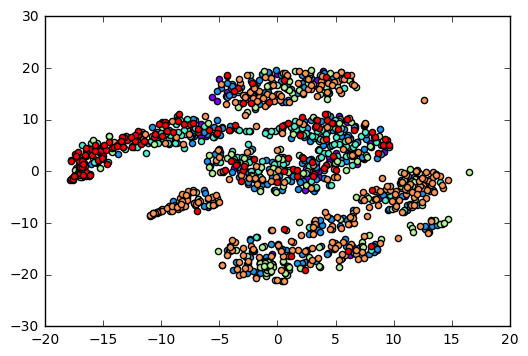

In [27]:
# ラベルなしクラスタリング結果(近傍ごとに色分け)
plot_clusters(_samples[unsupervised], _centroids, _true_y[unsupervised])

## 正解率評価(近傍と写像後の対応するID)

In [36]:
#accuracy_score(np.array([_label2id[_] for _ in train_y])[unsupervised],nearest[unsupervised])
accuracy_score(_true_y[unsupervised],   _near_y[unsupervised])


0.35537848605577688

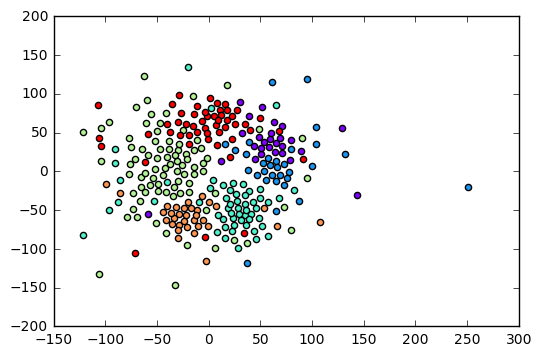

In [29]:
_samples=sess.run(pred_y, feed_dict={input_x:test_X})
    

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(centroids, np.arange(len(centroids)))
_nearest = neigh.predict(_samples)

# クラスタリング結果（正解ラベルごとに色分け）
plot_clusters(_samples, centroids, _nearest)

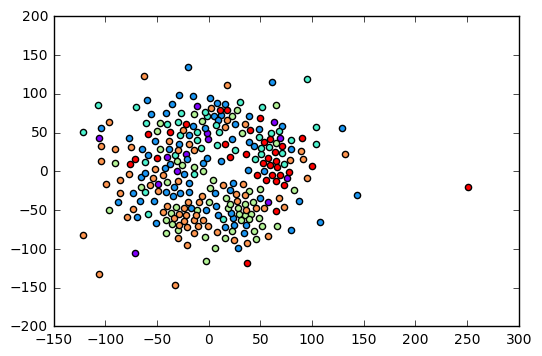

In [30]:
# クラスタリング結果（正解ラベルごとに色分け）
plot_clusters(_samples, centroids, test_y)

## GIFに書き出し

In [71]:
import subprocess

command='convert -layers optimize -loop 0 -delay 40 ../output/*.png ../img/out_main.gif'.split(" ")
res = subprocess.call(command)

In [31]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 28  15   3   4   3   3]
 [ 83 121  24  72  29   9]
 [ 71  30  34   9   2  22]
 [ 17  67   7  92  40   8]
 [ 22  84   8  91 105   2]
 [ 33  23  21   5   2  66]]


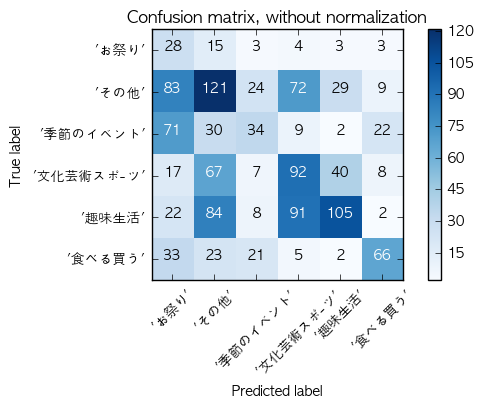

In [37]:
from sklearn.metrics import confusion_matrix

#id2label = {v: k for k, v in label2id.items()}

#cnf_matrix = confusion_matrix( np.array([label2id[_] for _ in train_y])[unsupervised],   nearest[unsupervised])
cnf_matrix = confusion_matrix( _true_y[unsupervised],   _near_y[unsupervised])

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()

import matplotlib as mpl
mpl.rcParams['font.family'] = 'AppleGothic'

#class_names=['食べる買う','文化芸術スポ-ツ','その他','趣味生活','お祭り','季節のイベント']
class_names=[v.replace("ー","-").replace("・","") for k,v in {v: k for k, v in label2Label.items()}.items()]
    
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [38]:
len(unsupervised)

1255